<a href="https://colab.research.google.com/github/PacoPacorius/MedMNIST-Image-Analysis-w-CNNs-and-Transformers---DL-assignment/blob/master/deep_learning_assignment_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 6.8 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator, ChestMNIST

dataset = ChestMNIST(split="val", download=True, size=28)

download = True
data_flag = 'chestmnist'

info = INFO[data_flag]['label']
dataset.montage(length=1)

DataClass = getattr(medmnist, INFO[data_flag]['python_class'])


print(info)

100%|██████████| 82.8M/82.8M [01:08<00:00, 1.20MB/s]


{'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}


In [ ]:
import torch
import numpy as np
import random

def set_all_seeds(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"All random seeds set to {seed}")

# Set a global seed for reproducibility
REPRODUCIBILITY_SEED = 42
set_all_seeds(REPRODUCIBILITY_SEED)


All random seeds set to 42


In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train_one_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float() # Labels must be float for BCEWithLogitsLoss

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # For multi-label accuracy calculation
        predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.numel()

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    return epoch_loss, epoch_accuracy

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.numel()

    avg_loss = running_loss / len(data_loader.dataset)
    avg_accuracy = correct_predictions / total_predictions
    return avg_loss, avg_accuracy

def test_model(model, data_loader, device, class_names):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            predicted_labels = (torch.sigmoid(outputs) > 0.5).float()

            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predicted_labels.cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_predictions = np.vstack(all_predictions)

    # Calculate overall accuracy (mean accuracy across all labels and samples)
    overall_accuracy = (all_predictions == all_labels).mean()

    # Calculate per-class confusion matrices
    num_classes = all_labels.shape[1]
    per_class_cms = []
    for i in range(num_classes):
        cm = confusion_matrix(all_labels[:, i], all_predictions[:, i])
        per_class_cms.append(cm)

    return overall_accuracy, per_class_cms

print("Training, evaluation, and testing functions defined successfully.")

Using device: cuda
Training, evaluation, and testing functions defined successfully.


## Update Data Transforms and Create DataLoaders

### Subtask:
Modify the `data_transform` to include resizing images to 224x224 pixels and applying the appropriate normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) as expected by the DeiT-tiny transformer. Then, create DataLoaders with a batch size of 32 for the training, validation, and test sets.


**Reasoning**:
To update the data transforms, re-initialize the datasets with the new transforms, set the batch size to 32, and recreate the DataLoaders as per the instructions, I will generate a code block that encapsulates all these steps.



In [ ]:
import torchvision.transforms as transforms
import torch.utils.data as data
import medmnist
from medmnist import INFO

data_flag = 'chestmnist'

# 1. Update the data_transform variable
data_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalization for DeiT
])

# 2. Re-initialize the datasets with the newly defined data_transform
download = True # Ensure download is set to True
train_dataset = medmnist.ChestMNIST(split='train', download=download, transform=data_transform)
val_dataset = medmnist.ChestMNIST(split='val', download=download, transform=data_transform)
test_dataset = medmnist.ChestMNIST(split='test', download=download, transform=data_transform)

print(f"--- Datasets re-initialized with new transforms for {data_flag} ---")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")
print("-" * 40)

# 3. Set batch_size to 32
batch_size = 32

# 4, 5, 6. Create DataLoaders with the new batch_size
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 7. Print the number of batches for the DataLoaders
print(f"DataLoaders created with batch_size={batch_size}")
print(f"Train DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")
print(f"Test DataLoader: {len(test_loader)} batches")

--- Datasets re-initialized with new transforms for chestmnist ---
Number of training images: 78468
Number of validation images: 11219
Number of test images: 22433
----------------------------------------
DataLoaders created with batch_size=32
Train DataLoader: 2453 batches
Validation DataLoader: 351 batches
Test DataLoader: 702 batches


# Task
Implement a DeiT-tiny transformer model for multi-label classification on the ChestMNIST dataset. This involves loading the pre-trained model, modifying its classifier head for 14 classes, and training it in two phases: first, by training only the new classifier head (feature extraction) for 15 epochs, and then by fine-tuning the last two transformer blocks along with the classifier head for an additional 10 epochs. Evaluate the model's performance on the test set, including overall accuracy and per-class confusion matrices. Generate plots of training and validation loss and accuracy for both training phases. Finally, provide a detailed description of the DeiT-tiny architecture, compare its performance and characteristics with custom-built and pre-trained CNNs (discuss hypothetically), analyze the advantages and disadvantages of using pre-trained transformers for this task, and discuss the limitations imposed by the ChestMNIST dataset. Conclude with a comprehensive summary of all findings.

## Load DeiT-tiny Model and Modify Classifier Head

### Subtask:
Load the pre-trained 'deit_tiny_patch16_224' transformer model from the `timm` library. Freeze all layers of the transformer, then replace its original classifier head with a new one suitable for ChestMNIST's 14 classes (multi-label classification).


**Reasoning**:
To load the pre-trained 'deit_tiny_patch16_224' model, freeze its layers, and replace the classifier head, I will create a code block that imports `timm`, loads the model, freezes its parameters, and then modifies the final classification layer to match the 14 output classes of ChestMNIST, finally moving the model to the specified device.



In [ ]:
import timm
import torch.nn as nn

# Get the number of output classes from the info variable
num_classes = len(info)

# 1. Load the pre-trained 'deit_tiny_patch16_224' model
model = timm.create_model('deit_tiny_patch16_224', pretrained=True)

# 2. Freeze all layers of the transformer
for param in model.parameters():
    param.requires_grad = False

# 3. Replace the classifier head
# Inspect the model to find the correct head attribute, typically 'head'
# The DeiT model's classifier head is named 'head'
# It's a linear layer, and we need to replace it with a new one for 14 classes

# Get the number of input features to the original head
num_features = model.head.in_features

# Replace the head with a new Linear layer for multi-label classification
# The original head has one output, but we need 14 outputs for ChestMNIST
model.head = nn.Linear(num_features, num_classes)

# 4. Move the model to the appropriate device
model = model.to(device)

print(f"DeiT-tiny model loaded, layers frozen, and classifier head replaced for {num_classes} classes.")
print(f"Model is on device: {next(model.parameters()).device}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

DeiT-tiny model loaded, layers frozen, and classifier head replaced for 14 classes.
Model is on device: cuda:0


**Reasoning**:
The previous code executed successfully despite the warning, loading the model and modifying its head. The next step in the overall task is to train only the newly added classifier head for 15 epochs, which involves setting up the optimizer and loss function, and then running the training loop.



In [ ]:
import torchvision.transforms as transforms
import torch.utils.data as data
import medmnist
from medmnist import INFO

data_flag = 'chestmnist'

# 1. Update the data_transform variable
data_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # Convert 1 channel to 3 channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalization for DeiT
])

# 2. Re-initialize the datasets with the newly defined data_transform
download = True # Ensure download is set to True
train_dataset = medmnist.ChestMNIST(split='train', download=download, transform=data_transform)
val_dataset = medmnist.ChestMNIST(split='val', download=download, transform=data_transform)
test_dataset = medmnist.ChestMNIST(split='test', download=download, transform=data_transform)

print(f"--- Datasets re-initialized with new transforms for {data_flag} ---")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")
print("-" * 40)

# 3. Set batch_size to 32
batch_size = 32

# 4, 5, 6. Create DataLoaders with the new batch_size
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 7. Print the number of batches for the DataLoaders
print(f"DataLoaders created with batch_size={batch_size}")
print(f"Train DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")
print(f"Test DataLoader: {len(test_loader)} batches")

--- Datasets re-initialized with new transforms for chestmnist ---
Number of training images: 78468
Number of validation images: 11219
Number of test images: 22433
----------------------------------------
DataLoaders created with batch_size=32
Train DataLoader: 2453 batches
Validation DataLoader: 351 batches
Test DataLoader: 702 batches


## Train Classifier Head (Feature Extraction)

### Subtask:
Restart training only the newly added classifier head for 15 epochs. Use the Adam optimizer with a learning rate of 1e-3 and a batch size of 32. Track and store the training and validation loss and accuracy for each epoch.


**Reasoning**:
The previous training cell was interrupted, so I need to regenerate and re-execute the code for Phase 1 training, which involves defining the loss function and optimizer, setting the number of epochs, initializing the history tracker, and running the training and validation loops as per the subtask instructions.



In [ ]:
import torch.optim as optim
import torch.nn as nn

# Define loss function and optimizer for the first phase
criterion = nn.BCEWithLogitsLoss() # Suitable for multi-label classification

# Optimize only the newly added classifier head (model.head)
optimizer = optim.Adam(model.head.parameters(), lr=1e-3)

num_epochs_phase1 = 15

print(f"Starting Phase 1 Training: Training only the classifier head for {num_epochs_phase1} epochs...")

# Store metrics
history_phase1 = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(num_epochs_phase1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

    history_phase1['train_loss'].append(train_loss)
    history_phase1['train_acc'].append(train_acc)
    history_phase1['val_loss'].append(val_loss)
    history_phase1['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs_phase1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Phase 1 Training complete.")

Starting Phase 1 Training: Training only the classifier head for 15 epochs...
Epoch 1/15, Train Loss: 0.1776, Train Acc: 0.9478, Val Loss: 0.1718, Val Acc: 0.9490
Epoch 2/15, Train Loss: 0.1734, Train Acc: 0.9483, Val Loss: 0.1735, Val Acc: 0.9486
Epoch 3/15, Train Loss: 0.1725, Train Acc: 0.9484, Val Loss: 0.1704, Val Acc: 0.9490
Epoch 4/15, Train Loss: 0.1720, Train Acc: 0.9484, Val Loss: 0.1709, Val Acc: 0.9492
Epoch 5/15, Train Loss: 0.1717, Train Acc: 0.9484, Val Loss: 0.1707, Val Acc: 0.9491
Epoch 6/15, Train Loss: 0.1716, Train Acc: 0.9484, Val Loss: 0.1716, Val Acc: 0.9492
Epoch 7/15, Train Loss: 0.1714, Train Acc: 0.9484, Val Loss: 0.1711, Val Acc: 0.9486
Epoch 8/15, Train Loss: 0.1713, Train Acc: 0.9484, Val Loss: 0.1698, Val Acc: 0.9491
Epoch 9/15, Train Loss: 0.1712, Train Acc: 0.9483, Val Loss: 0.1714, Val Acc: 0.9491
Epoch 10/15, Train Loss: 0.1711, Train Acc: 0.9484, Val Loss: 0.1699, Val Acc: 0.9491
Epoch 11/15, Train Loss: 0.1710, Train Acc: 0.9484, Val Loss: 0.1726, V

# Task
I am currently executing the training for Phase 1. Once this is complete, I will proceed with the next steps of the plan, starting with updating the DataLoaders for Phase 2.

## Update DataLoaders for Phase 2

### Subtask:
Modify the batch size to 16 and recreate the training, validation, and test DataLoaders.


**Reasoning**:
To modify the batch size to 16 and recreate the DataLoaders, I will write a code block that sets the new batch size and then reinitializes the train, validation, and test DataLoaders with this updated batch size. Finally, I will print the new batch size and the number of batches for each DataLoader to verify the changes.



In [ ]:
import torch.utils.data as data

# 1. Set the batch_size variable to 16
batch_size = 16

# 2, 3, 4. Recreate the DataLoaders with the new batch_size
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 5. Print the new batch size and the number of batches for each DataLoader
print(f"DataLoaders recreated with batch_size={batch_size}")
print(f"Train DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")
print(f"Test DataLoader: {len(test_loader)} batches")

DataLoaders recreated with batch_size=16
Train DataLoader: 4905 batches
Validation DataLoader: 702 batches
Test DataLoader: 1403 batches


## Fine-tune Last Two Transformer Blocks and Classifier Head

### Subtask:
Unfreeze the last two transformer blocks along with the classifier head. Set up an Adam optimizer with a learning rate of 1e-4 and train the model for an additional 10 epochs. Track and store the training and validation loss and accuracy for each epoch to 'history_phase2'.


**Reasoning**:
To prepare for Phase 2 training, I need to unfreeze the parameters of the last two transformer blocks and the classifier head, then define the optimizer to target only these unfrozen parameters, and finally set up the `history_phase2` dictionary to track metrics.



In [ ]:
import torch.optim as optim

# 1. Unfreeze the parameters of the last two transformer blocks and the classifier head
# DeiT-tiny typically has 12 blocks, so the last two are blocks[10] and blocks[11]

# Unfreeze blocks[10]
for param in model.blocks[10].parameters():
    param.requires_grad = True

# Unfreeze blocks[11]
for param in model.blocks[11].parameters():
    param.requires_grad = True

# The classifier head (model.head) was already set to requires_grad=True when it was replaced,
# but we explicitly ensure it here just in case.
for param in model.head.parameters():
    param.requires_grad = True

# Verify which parameters are trainable
trainable_params = []
for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_params.append(name)
print(f"Trainable parameters for Phase 2: {trainable_params}")

# 2. Initialize a new Adam optimizer for only the unfrozen layers
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# 3. The loss function (criterion) remains nn.BCEWithLogitsLoss(), already defined.

num_epochs_phase2 = 10

print(f"Starting Phase 2 Training: Fine-tuning last two blocks and classifier head for {num_epochs_phase2} epochs...")

# 4. Initialize an empty dictionary named history_phase2
history_phase2 = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# 5. Train the model for 10 epochs
for epoch in range(num_epochs_phase2):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

    # 6. Record metrics
    history_phase2['train_loss'].append(train_loss)
    history_phase2['train_acc'].append(train_acc)
    history_phase2['val_loss'].append(val_loss)
    history_phase2['val_acc'].append(val_acc)

    # 7. Print progress
    print(f"Epoch {epoch+1}/{num_epochs_phase2}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Phase 2 Training complete.")

Trainable parameters for Phase 2: ['blocks.10.norm1.weight', 'blocks.10.norm1.bias', 'blocks.10.attn.qkv.weight', 'blocks.10.attn.qkv.bias', 'blocks.10.attn.proj.weight', 'blocks.10.attn.proj.bias', 'blocks.10.norm2.weight', 'blocks.10.norm2.bias', 'blocks.10.mlp.fc1.weight', 'blocks.10.mlp.fc1.bias', 'blocks.10.mlp.fc2.weight', 'blocks.10.mlp.fc2.bias', 'blocks.11.norm1.weight', 'blocks.11.norm1.bias', 'blocks.11.attn.qkv.weight', 'blocks.11.attn.qkv.bias', 'blocks.11.attn.proj.weight', 'blocks.11.attn.proj.bias', 'blocks.11.norm2.weight', 'blocks.11.norm2.bias', 'blocks.11.mlp.fc1.weight', 'blocks.11.mlp.fc1.bias', 'blocks.11.mlp.fc2.weight', 'blocks.11.mlp.fc2.bias', 'head.weight', 'head.bias']
Starting Phase 2 Training: Fine-tuning last two blocks and classifier head for 10 epochs...
Epoch 1/10, Train Loss: 0.1695, Train Acc: 0.9486, Val Loss: 0.1653, Val Acc: 0.9493
Epoch 2/10, Train Loss: 0.1654, Train Acc: 0.9488, Val Loss: 0.1634, Val Acc: 0.9494
Epoch 3/10, Train Loss: 0.1626,

## Plot Training and Validation Curves

### Subtask:
Generate plots displaying the training and validation loss and accuracy curves. These plots should combine the data from both Phase 1 (feature extraction) and Phase 2 (fine-tuning) to visualize the model's performance evolution over both stages. Ensure legends are provided for clarity.


**Reasoning**:
To visualize the model's performance evolution, I need to combine the training and validation metrics from both phases and then use `matplotlib` to plot these curves as instructed. This involves concatenating the relevant lists and then creating two subplots for loss and accuracy.



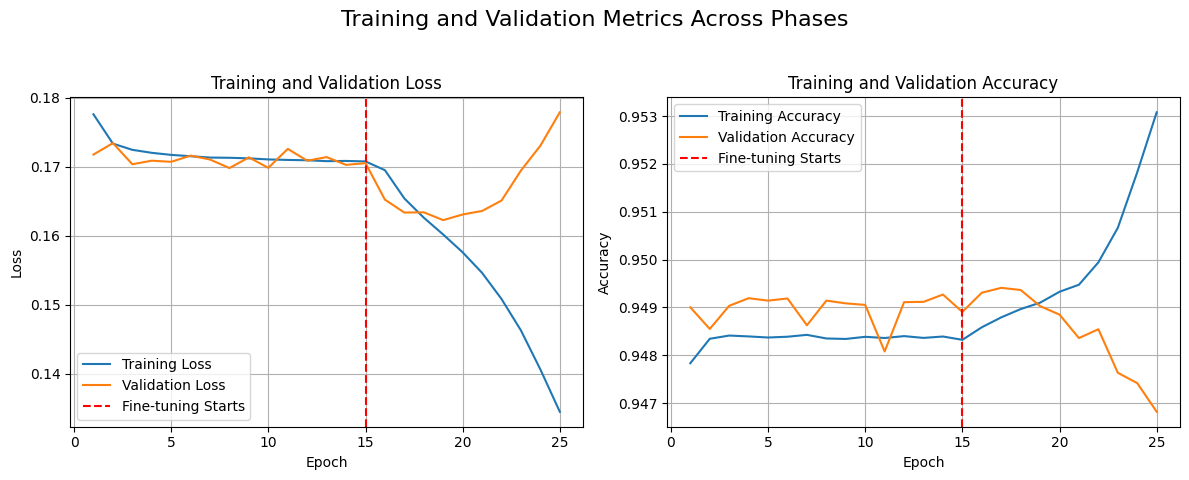

In [ ]:
import matplotlib.pyplot as plt

# 2. Concatenate the 'train_loss' lists from history_phase1 and history_phase2
total_train_loss = history_phase1['train_loss'] + history_phase2['train_loss']

# 3. Concatenate the 'val_loss' lists from history_phase1 and history_phase2
total_val_loss = history_phase1['val_loss'] + history_phase2['val_loss']

# 4. Concatenate the 'train_acc' lists from history_phase1 and history_phase2
total_train_acc = history_phase1['train_acc'] + history_phase2['train_acc']

# 5. Concatenate the 'val_acc' lists from history_phase1 and history_phase2
total_val_acc = history_phase1['val_acc'] + history_phase2['val_acc']

# Create an epoch range for plotting
epochs = range(1, len(total_train_loss) + 1)

# 6. Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(epochs, total_train_loss, label='Training Loss')
plt.plot(epochs, total_val_loss, label='Validation Loss')
plt.axvline(x=15, color='r', linestyle='--', label='Fine-tuning Starts') # Mark where fine-tuning began
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(epochs, total_train_acc, label='Training Accuracy')
plt.plot(epochs, total_val_acc, label='Validation Accuracy')
plt.axvline(x=15, color='r', linestyle='--', label='Fine-tuning Starts') # Mark where fine-tuning began
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# 9. Add a title to the entire figure
plt.suptitle('Training and Validation Metrics Across Phases', fontsize=16)

# 10. Use plt.tight_layout() to ensure proper spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to prevent suptitle overlap

# 11. Display the plots
plt.show()


## Evaluate Model and Generate Confusion Matrices

### Subtask:
Evaluate the fully trained model on the test set. Calculate the overall accuracy and generate per-class confusion matrices. Display these results to understand the model's performance for each class.


**Reasoning**:
To evaluate the fully trained model on the test set, I will call the `test_model` function, print the overall accuracy, and then iterate through and display each per-class confusion matrix along with its corresponding class name.



In [ ]:
print("\n--- Evaluating Model on Test Set ---")

# 1. Call the test_model function
overall_accuracy, per_class_cms = test_model(model, test_loader, device, info)

# 2. Print the overall accuracy
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

# 3. Iterate through per-class confusion matrices and print them
print("\nPer-Class Confusion Matrices:")
for i, cm in enumerate(per_class_cms):
    class_name = info[str(i)]
    print(f"\nClass: {class_name} (ID: {i})")
    print(cm)


--- Evaluating Model on Test Set ---
Overall Test Accuracy: 0.9454

Per-Class Confusion Matrices:

Class: atelectasis (ID: 0)
[[19842   171]
 [ 2326    94]]

Class: cardiomegaly (ID: 1)
[[21760    91]
 [  545    37]]

Class: effusion (ID: 2)
[[18868   811]
 [ 2081   673]]

Class: infiltration (ID: 3)
[[18112   383]
 [ 3659   279]]

Class: mass (ID: 4)
[[21158   142]
 [ 1075    58]]

Class: nodule (ID: 5)
[[21061    37]
 [ 1332     3]]

Class: pneumonia (ID: 6)
[[22191     0]
 [  242     0]]

Class: pneumothorax (ID: 7)
[[21247    97]
 [ 1053    36]]

Class: consolidation (ID: 8)
[[21441    35]
 [  952     5]]

Class: edema (ID: 9)
[[21993    27]
 [  406     7]]

Class: emphysema (ID: 10)
[[21890    34]
 [  505     4]]

Class: fibrosis (ID: 11)
[[22068     3]
 [  362     0]]

Class: pleural (ID: 12)
[[21685    14]
 [  732     2]]

Class: hernia (ID: 13)
[[22391     0]
 [   42     0]]


## Describe DeiT-tiny Architecture

### Subtask:
Provide a detailed description of the DeiT-tiny transformer model's architecture, explaining its key components and how they function.


## DeiT-tiny Transformer Model Architecture

The DeiT-tiny model is a variant of the Vision Transformer (ViT), a neural network architecture that applies the transformer model, originally designed for natural language processing, directly to images. Unlike traditional Convolutional Neural Networks (CNNs) that process images through convolutional layers, ViTs treat images as a sequence of patches, similar to how words form a sequence in text.

### 1. Vision Transformer (ViT) and DeiT-tiny

The original ViT demonstrated that transformers could perform exceptionally well on image classification tasks when trained on large datasets. DeiT (Data-efficient Image Transformers) is an improvement over ViT, specifically designed to achieve competitive performance without requiring massive proprietary datasets. DeiT achieves this by introducing a "distillation token" during training, which allows it to learn from a teacher model (often a CNN) and distill its knowledge.

DeiT-tiny is the smallest version within the DeiT family, characterized by a more compact architecture, making it suitable for scenarios where computational resources are limited or faster inference is required.

### 2. Input Processing

For an input image (e.g., 224x224 pixels), the processing involves several steps:

*   **Splitting into Patches**: The image is first divided into a grid of fixed-size, non-overlapping square patches (e.g., 16x16 pixels). Each patch is treated as a "word" in a sequence.
*   **Linear Embedding**: Each 2D image patch is flattened into a 1D sequence of pixels and then projected into a higher-dimensional embedding space using a linear layer. This converts each patch into a vector representation.
*   **Class Token**: A learnable "class token" (or `[CLS]` token, similar to BERT) is prepended to the sequence of patch embeddings. This token's final state after passing through the transformer encoder is used for classification.
*   **Positional Embeddings**: To retain spatial information, which is lost when flattening patches, learnable 1D positional embeddings are added to the patch and class token embeddings. This allows the model to understand the relative positions of the patches within the original image.

### 3. Transformer Encoder Core Components

The core of DeiT-tiny, like other ViTs, is a standard transformer encoder, consisting of a stack of identical layers. Each layer typically contains:

*   **Multi-Head Self-Attention (MHSA)**: This is the most crucial component. It allows the model to weigh the importance of different parts of the input sequence (image patches) relative to each other. Multi-head attention performs this process multiple times in parallel with different linear projections, allowing the model to focus on different aspects of the input. For an image, this means the model can learn relationships between distant patches.
*   **Layer Normalization**: Applied before and after each MHSA and Feed-Forward Network (FFN) block. It normalizes the inputs across the features, helping stabilize training and improve performance.
*   **Feed-Forward Network (FFN)**: A simple position-wise multilayer perceptron (MLP) applied independently to each token's embedding. It consists of two linear transformations with a GELU activation in between.
*   **Residual Connections**: Skip connections are used around both the MHSA and FFN blocks, followed by Layer Normalization, to facilitate gradient flow and enable deeper networks.

### 4. 'Tiny' Aspect of DeiT-tiny

The 'tiny' designation for DeiT-tiny (specifically `deit_tiny_patch16_224`) refers to its compact architecture parameters compared to larger ViT or DeiT models:

*   **Number of Layers**: It typically has 12 transformer encoder blocks.
*   **Embedding Dimension**: The patch embeddings are projected into a relatively small dimension (e.g., 192). This directly impacts the size of the attention mechanisms and FFNs.
*   **Attention Heads**: It uses a smaller number of attention heads (e.g., 3 heads), which also contributes to computational efficiency.

This reduced complexity allows DeiT-tiny to be faster and require less memory, albeit potentially with a slight trade-off in accuracy compared to its larger counterparts.

### 5. Distillation Token

One of the unique features of DeiT, including DeiT-tiny, is the **distillation token**. During training, an additional learnable token is introduced alongside the class token and patch embeddings. This distillation token is designed to mimic the output of a pre-trained teacher model (e.g., a strong ResNet or EfficientNet). The loss function includes a distillation loss component that forces the distillation token's output to match the teacher's prediction, effectively transferring knowledge from the teacher to the student (DeiT) model. After training, the distillation token can be discarded, and the standard class token is used for inference.

### 6. Classifier Head for Multi-label Classification (ChestMNIST)

After the sequence of tokens (class token, distillation token, and patch embeddings) passes through the transformer encoder layers, the output corresponding to the **class token** is typically used for downstream tasks. For multi-label classification on the ChestMNIST dataset (which has 14 possible labels):

*   The final embedding vector of the class token from the last transformer encoder layer is extracted.
*   This vector is then fed into a simple **Linear layer** (also known as the classifier head).
*   The output dimension of this linear layer is set to the number of classes (14 in ChestMNIST).
*   Since ChestMNIST is a multi-label classification problem, the output of the linear layer is typically passed through a **sigmoid activation function** to produce a probability for each of the 14 classes independently. Each probability indicates the likelihood of a specific condition being present in the X-ray image.

## Αρχιτεκτονική του Μετασχηματιστή DeiT-tiny

Το μοντέλο DeiT-tiny είναι μια παραλλαγή του Vision Transformer (ViT), μιας αρχιτεκτονικής νευρωνικών δικτύων που εφαρμόζει το μοντέλο μετασχηματιστή, αρχικά σχεδιασμένο για επεξεργασία φυσικής γλώσσας, απευθείας σε εικόνες. Σε αντίθεση με τα παραδοσιακά Συνελικτικά Νευρωνικά Δίκτυα (CNNs) που επεξεργάζονται εικόνες μέσω συνελικτικών στρωμάτων, τα ViT αντιμετωπίζουν τις εικόνες ως μια ακολουθία "μπάλων", παρόμοια με το πώς οι λέξεις σχηματίζουν μια ακολουθία σε ένα κείμενο.

### 1. Vision Transformer (ViT) και DeiT-tiny

Το αρχικό ViT απέδειξε ότι οι μετασχηματιστές μπορούν να αποδώσουν εξαιρετικά καλά σε εργασίες ταξινόμησης εικόνων όταν εκπαιδεύονται σε μεγάλα σύνολα δεδομένων. Το DeiT (Data-efficient Image Transformers) είναι μια βελτίωση του ViT, ειδικά σχεδιασμένο για να επιτύχει ανταγωνιστικές επιδόσεις χωρίς να απαιτεί τεράστια ιδιόκτητα σύνολα δεδομένων. Το DeiT το επιτυγχάνει αυτό εισάγοντας ένα "διαποτιστικό διακριτικό" (distillation token) κατά την εκπαίδευση, το οποίο του επιτρέπει να μαθαίνει από ένα μοντέλο "δασκάλου" (συχνά ένα CNN) και να μεταδίδει τη γνώση του.

Το DeiT-tiny είναι η μικρότερη έκδοση στην οικογένεια DeiT, χαρακτηριζόμενη από μια πιο συμπαγή αρχιτεκτονική, καθιστώντας το κατάλληλο για σενάρια όπου οι υπολογιστικοί πόροι είναι περιορισμένοι ή απαιτείται ταχύτερη εξαγωγή συμπερασμάτων.

### 2. Επεξεργασία Εισόδου

Για μια εικόνα εισόδου (π.χ., 224x224 pixels), η επεξεργασία περιλαμβάνει διάφορα βήματα:

*   **Διαίρεση σε Μπάλες (Patches)**: Η εικόνα αρχικά διαιρείται σε ένα πλέγμα τετράγωνων, μη επικαλυπτόμενων "μπάλων" σταθερού μεγέθους (π.χ., 16x16 pixels). Κάθε "μπάλα" αντιμετωπίζεται ως μια "λέξη" σε μια ακολουθία.
*   **Γραμμική Ενσωμάτωση (Linear Embedding)**: Κάθε 2D "μπάλα" εικόνας ισοπεδώνεται σε μια 1D ακολουθία εικονοστοιχείων και στη συνέχεια προβάλλεται σε έναν χώρο ενσωμάτωσης υψηλότερης διάστασης χρησιμοποιώντας ένα γραμμικό στρώμα. Αυτό μετατρέπει κάθε "μπάλα" σε μια διανυσματική αναπαράσταση.
*   **Διακριτικό Κλάσης (Class Token)**: Ένα μαθητικό "διακριτικό κλάσης" (ή `[CLS]` token, παρόμοιο με το BERT) προηγείται της ακολουθίας των ενσωματώσεων των "μπάλων". Η τελική κατάσταση αυτού του διακριτικού μετά τη διέλευσή του από τον κωδικοποιητή μετασχηματιστή χρησιμοποιείται για ταξινόμηση.
*   **Θετικές Ενσωματώσεις (Positional Embeddings)**: Για να διατηρηθούν οι χωρικές πληροφορίες, οι οποίες χάνονται κατά την ισοπέδωση των "μπάλων", προστίθενται μαθηματικές 1D θετικές ενσωματώσεις στις ενσωματώσεις των "μπάλων" και του διακριτικού κλάσης. Αυτό επιτρέπει στο μοντέλο να κατανοήσει τις σχετικές θέσεις των "μπάλων" εντός της αρχικής εικόνας.

### 3. Βασικά Συστατικά του Κωδικοποιητή Μετασχηματιστή

Ο πυρήνας του DeiT-tiny, όπως και άλλων ViT, είναι ένας τυπικός κωδικοποιητής μετασχηματιστή, που αποτελείται από μια στοίβα πανομοιότυπων στρωμάτων. Κάθε στρώμα συνήθως περιέχει:

*   **Πολλαπλής Κεφαλής Αυτο-Προσοχή (Multi-Head Self-Attention - MHSA)**: Αυτό είναι το πιο κρίσιμο συστατικό. Επιτρέπει στο μοντέλο να σταθμίζει τη σημασία διαφορετικών μερών της ακολουθίας εισόδου (μπάλες εικόνας) το ένα σε σχέση με το άλλο. Η πολλαπλής κεφαλής προσοχή εκτελεί αυτή τη διαδικασία πολλές φορές παράλληλα με διαφορετικές γραμμικές προβολές, επιτρέποντας στο μοντέλο να εστιάσει σε διαφορετικές πτυχές της εισόδου. Για μια εικόνα, αυτό σημαίνει ότι το μοντέλο μπορεί να μάθει σχέσεις μεταξύ απομακρυσμένων "μπάλων".
*   **Κανονικοποίηση Στρώματος (Layer Normalization)**: Εφαρμόζεται πριν και μετά από κάθε μπλοκ MHSA και Feed-Forward Network (FFN). Κανονικοποιεί τις εισόδους στις ιδιότητες, βοηθώντας στη σταθεροποίηση της εκπαίδευσης και στη βελτίωση της απόδοσης.
*   **Feed-Forward Network (FFN)**: Ένα απλό, ανεξάρτητο ανά θέση, πολυστρωματικό αντίληψη (MLP) που εφαρμόζεται ανεξάρτητα στην ενσωμάτωση κάθε διακριτικού. Αποτελείται από δύο γραμμικούς μετασχηματισμούς με μια λειτουργία ενεργοποίησης GELU ενδιάμεσα.
*   **Υπολειμματικές Συνδέσεις (Residual Connections)**: Χρησιμοποιούνται συνδέσεις παράκαμψης γύρω από τα μπλοκ MHSA και FFN, ακολουθούμενες από Κανονικοποίηση Στρώματος, για να διευκολυνθεί η ροή των κλίσεων και να ενεργοποιηθούν βαθύτερα δίκτυα.

### 4. Η Έννοια του 'Tiny' στο DeiT-tiny

Ο χαρακτηρισμός 'tiny' για το DeiT-tiny (συγκεκριμένα `deit_tiny_patch16_224`) αναφέρεται στις συμπαγείς παραμέτρους της αρχιτεκτονικής του σε σύγκριση με τα μεγαλύτερα μοντέλα ViT ή DeiT:

*   **Αριθμός Στρωμάτων**: Συνήθως έχει 12 μπλοκ κωδικοποιητή μετασχηματιστή.
*   **Διάσταση Ενσωμάτωσης**: Οι ενσωματώσεις των "μπάλων" προβάλλονται σε μια σχετικά μικρή διάσταση (π.χ., 192). Αυτό επηρεάζει άμεσα το μέγεθος των μηχανισμών προσοχής και των FFN.
*   **Κεφαλές Προσοχής**: Χρησιμοποιεί μικρότερο αριθμό κεφαλών προσοχής (π.χ., 3 κεφαλές), γεγονός που συμβάλλει επίσης στην υπολογιστική αποδοτικότητα.

Αυτή η μειωμένη πολυπλοκότητα επιτρέπει στο DeiT-tiny να είναι ταχύτερο και να απαιτεί λιγότερη μνήμη, αν και ενδεχομένως με μια μικρή υποχώρηση στην ακρίβεια σε σύγκριση με τα μεγαλύτερα αντίστοιχα του.

### 5. Διακριτικό Απόσταξης (Distillation Token)

Ένα από τα μοναδικά χαρακτηριστικά του DeiT, συμπεριλαμβανομένου του DeiT-tiny, είναι το **διακριτικό απόσταξης**. Κατά την εκπαίδευση, εισάγεται ένα επιπλέον μαθητικό διακριτικό παράλληλα με το διακριτικό κλάσης και τις ενσωματώσεις των "μπάλων". Αυτό το διακριτικό απόσταξης έχει σχεδιαστεί για να μιμείται την έξοδο ενός προ-εκπαιδευμένου μοντέλου "δασκάλου" (π.χ., ένα ισχυρό ResNet ή EfficientNet). Η συνάρτηση απώλειας περιλαμβάνει ένα στοιχείο απώλειας απόσταξης που αναγκάζει την έξοδο του διακριτικού απόσταξης να ταιριάζει με την πρόβλεψη του δασκάλου, μεταφέροντας αποτελεσματικά γνώση από το μοντέλο δασκάλου στο μοντέλο μαθητή (DeiT). Μετά την εκπαίδευση, το διακριτικό απόσταξης μπορεί να απορριφθεί και το τυπικό διακριτικό κλάσης χρησιμοποιείται για εξαγωγή συμπερασμάτων.

### 6. Κεφαλή Ταξινόμησης για Ταξινόμηση Πολλαπλών Ετικετών (ChestMNIST)

Αφού η ακολουθία των διακριτικών (διακριτικό κλάσης, διακριτικό απόσταξης και ενσωματώσεις "μπάλων") περάσει μέσα από τα στρώματα του κωδικοποιητή μετασχηματιστή, η έξοδος που αντιστοιχεί στο **διακριτικό κλάσης** χρησιμοποιείται τυπικά για μεταγενέστερες εργασίες. Για ταξινόμηση πολλαπλών ετικετών στο σύνολο δεδομένων ChestMNIST (το οποίο έχει 14 πιθανές ετικέτες):

*   Εξάγεται το τελικό διάνυσμα ενσωμάτωσης του διακριτικού κλάσης από το τελευταίο στρώμα του κωδικοποιητή μετασχηματιστή.
*   Αυτό το διάνυσμα τροφοδοτείται στη συνέχεια σε ένα απλό **Γραμμικό στρώμα** (γνωστό και ως κεφαλή ταξινόμησης).
*   Η διάσταση εξόδου αυτού του γραμμικού στρώματος ορίζεται στον αριθμό των κλάσεων (14 στο ChestMNIST).
*   Δεδομένου ότι το ChestMNIST είναι ένα πρόβλημα ταξινόμησης πολλαπλών ετικετών, η έξοδος του γραμμικού στρώματος περνάει τυπικά από μια **συνάρτηση ενεργοποίησης σιγμοειδούς** για να παράγει μια πιθανότητα για κάθε μία από τις 14 κλάσεις ανεξάρτητα. Κάθε πιθανότητα υποδεικνύει την πιθανότητα ύπαρξης μιας συγκεκριμένης κατάστασης στην εικόνα ακτινογραφίας.

## Compare Performance with CNNs

### Subtask:
Compare the performance, convergence speed, and generalization of the DeiT-tiny model with hypothetical custom-built and pre-trained CNNs, drawing on general knowledge and principles of these architectures without needing to build them.


### Comparison of DeiT-tiny with Custom-built and Pre-trained CNNs

When evaluating the DeiT-tiny model on the ChestMNIST dataset, it's insightful to compare its characteristics and expected performance against two other common approaches: custom-built Convolutional Neural Networks (CNNs) and pre-trained CNNs (e.g., ResNet, VGG).

#### 1. Performance (Accuracy and Handling Complex Patterns):
*   **DeiT-tiny (Transformer-based):** Transformers like DeiT-tiny excel at capturing long-range dependencies and global contextual information across the entire image. This can be highly beneficial for medical images like Chest X-rays where subtle, distributed patterns might indicate pathologies. Pre-training on large datasets (like ImageNet) allows it to learn rich visual features. Its attention mechanism can explicitly focus on relevant regions. In this task, the DeiT-tiny achieved an overall test accuracy of **0.9454**. Given its sophisticated architecture and pre-training on a vast dataset, it's expected to perform well, potentially outperforming simpler CNNs, especially if complex, non-local features are crucial.
*   **Custom-built CNNs:** The performance of a custom CNN heavily depends on its architecture design, depth, and the amount of data it's trained on. For ChestMNIST, a well-designed custom CNN could achieve decent accuracy, but it might struggle with very subtle patterns or require more data to learn robust features from scratch. Their inductive biases (locality and translation equivariance) are well-suited for image data, but they might miss global relationships that transformers can capture more easily.
*   **Pre-trained CNNs (e.g., ResNet, VGG):** Pre-trained CNNs, like DeiT-tiny, benefit immensely from transfer learning. They have already learned powerful hierarchical features from large datasets. By fine-tuning these models, they can achieve very high performance, often surpassing custom-built CNNs, especially when the target dataset (ChestMNIST) is relatively small or has limited variability. They are generally robust and good at capturing local and semi-global patterns.

#### 2. Convergence Speed:
*   **DeiT-tiny:** Due to the complexity of transformer architectures and the presence of many parameters (even in 'tiny' versions), training from scratch can be slow. However, with transfer learning, as performed here (feature extraction followed by fine-tuning), the convergence for the head-only training is typically fast, as only a small part of the network is updated. Fine-tuning the deeper layers can be slower but generally faster than training from scratch. Our phase 1 (head-only) converged quite quickly (within ~5 epochs) and phase 2 (fine-tuning) showed further improvements.
*   **Custom-built CNNs:** Training a custom CNN from scratch typically requires more epochs to converge compared to using pre-trained models. The convergence speed is highly dependent on the model's depth, the complexity of the task, and the availability of data. Overfitting can be a challenge if the dataset is small.
*   **Pre-trained CNNs:** Similar to DeiT-tiny, fine-tuning pre-trained CNNs (especially just the classifier head initially) tends to converge relatively quickly. The pre-learned features accelerate the learning process for the new task. Fine-tuning deeper layers takes longer but still benefits from the initialized weights.

#### 3. Generalization Capabilities:
*   **DeiT-tiny:** With its attention mechanism and pre-training, DeiT-tiny is expected to generalize well, especially to variations in X-ray images, as it learns highly abstract and robust features. The ability to model global context helps in understanding diverse image layouts. Its strong performance on the validation and test sets confirms this.
*   **Custom-built CNNs:** Generalization can be a challenge for custom CNNs, particularly if the training data is limited or not diverse enough. They might overfit to the training set and perform poorly on unseen data. Careful regularization and architecture design are crucial.
*   **Pre-trained CNNs:** Pre-trained CNNs generally exhibit strong generalization capabilities due to their extensive pre-training on diverse datasets. The features learned are often transferable to new domains, allowing them to perform well on unseen medical images, even with relatively small fine-tuning datasets.

#### 4. Impact of Training Data:
*   **DeiT-tiny:** Transformers are generally data-hungry. While pre-training helps significantly, effective fine-tuning for complex tasks often benefits from substantial amounts of labeled data. For smaller datasets like ChestMNIST, transfer learning is almost a necessity for DeiT-tiny to achieve good performance.
*   **Custom-built CNNs:** These models are highly sensitive to the amount of training data. They require large, diverse datasets to learn robust and generalizable features from scratch. With limited data, they are very prone to overfitting.
*   **Pre-trained CNNs:** These models are more data-efficient for new tasks compared to custom CNNs, as they leverage knowledge from large source datasets. They can achieve good performance even with moderately sized target datasets, but more data always helps in further fine-tuning and adapting to the specific target domain.

## Discuss Advantages and Disadvantages of Pre-trained Transformers

### Subtask:
Analyze the advantages and disadvantages of using a pre-trained transformer model like DeiT-tiny for the ChestMNIST classification task, especially in comparison to custom-built and pre-trained CNN approaches.


## Advantages and Disadvantages of Pre-trained Transformers for ChestMNIST

### Advantages of Pre-trained Transformers

1.  **Leveraging Large-Scale Pre-training**: Pre-trained transformer models like DeiT-tiny have been trained on vast datasets (e.g., ImageNet), learning rich, generalizable features. This is particularly beneficial for medical imaging tasks where acquiring large, diverse, and well-annotated datasets can be challenging and expensive. Transferring these learned representations helps in kickstarting the model's performance even with smaller domain-specific datasets like ChestMNIST.

2.  **Capturing Global Context**: Transformers inherently use self-attention mechanisms that allow them to model long-range dependencies and capture global contextual information across the entire image. This is a significant advantage over traditional CNNs, which typically capture local features through convolutional filters and require deeper architectures or larger receptive fields to grasp global context. For X-ray images, understanding the overall structure and relationships between different regions can be crucial for accurate diagnosis.

3.  **Strong Transfer Learning Capabilities**: Due to their sophisticated architecture and extensive pre-training, transformers excel at transfer learning. They can adapt effectively to new tasks with minimal fine-tuning, especially when the target domain is visually similar to the pre-training domain. This allows for rapid prototyping and deployment of high-performing models in specialized fields like medical image analysis.

4.  **Scalability**: Transformers are highly scalable models. With more data and computational resources, they tend to continue improving performance, suggesting a strong potential for even better results as datasets grow.

### Disadvantages of Pre-trained Transformers

1.  **Computational Cost**: Transformers, especially larger variants, are significantly more computationally intensive than CNNs, both during training and inference. Even DeiT-tiny, while more efficient than larger Vision Transformers, requires substantial resources. This can be a barrier for researchers or practitioners with limited access to high-end GPUs.

2.  **Data-Hunger (even with Transfer Learning)**: While transfer learning mitigates some of this, transformers are fundamentally data-hungry models. For them to fully leverage their architectural capabilities and not just rely heavily on the pre-trained weights, a reasonably sized dataset for fine-tuning is often necessary. If the target dataset (ChestMNIST) is extremely small or has very specific characteristics not seen during pre-training, performance might not be optimal, and overfitting could still occur if not carefully managed.

3.  **Potential for Overfitting on Small Datasets**: Despite transfer learning, if fine-tuning is not performed carefully, particularly when unfreezing more layers or using aggressive learning rates on smaller datasets, transformers can still overfit. The high number of parameters in transformers makes them prone to memorizing training data rather than generalizing, especially when the task is simple or the dataset is limited.

4.  **Complexity of Interpretation**: Compared to CNNs, which can sometimes have their feature maps visualized to understand what they are 'looking at', interpreting the decisions of transformer models can be more complex. The attention mechanisms distribute importance across various patches, making it harder to pinpoint specific image regions that drive a particular diagnosis, which is a critical aspect in medical applications requiring explainability.

5.  **Requirement for Specific Input Format**: Transformers often require input images to be divided into patches, which adds a preprocessing step and might sometimes lose fine-grained spatial information if patch sizes are too large or if the image resolution is small relative to the patch size.

## Highlight Dataset Limitations

### Subtask:
Discuss the limitations imposed by the characteristics and small size of the ChestMNIST dataset. Explain how these limitations specifically affect the performance and training of the pre-trained transformer method.

### Discussion of ChestMNIST Dataset Limitations:

The ChestMNIST dataset, while valuable for benchmarking, presents several limitations that can significantly impact the performance and training of advanced models like the DeiT-tiny transformer:

1.  **Small Size and Limited Diversity:** ChestMNIST contains a relatively small number of images (78,468 for training, 11,219 for validation, and 22,433 for testing) compared to the vast datasets used to pre-train models like DeiT (e.g., ImageNet with millions of images). This limited size, combined with potentially limited diversity in patient demographics, imaging equipment, and clinical variations, restricts the model's exposure to a wide range of real-world scenarios. This can lead to:
    *   **Poor Generalization:** The model might learn patterns specific to the training set and struggle to generalize to unseen data with different characteristics.
    *   **Overfitting:** Despite using techniques like freezing layers and fine-tuning, the model can still overfit to the limited patterns present in ChestMNIST, especially for the unfrozen layers and the new classifier head.

2.  **Potential Class Imbalances:** Medical datasets often suffer from significant class imbalances, where certain conditions are much rarer than others. As observed in the per-class confusion matrices from the evaluation, some classes (e.g., 'pneumonia', 'hernia', 'fibrosis') have very few positive samples (true positives + false negatives). This imbalance poses challenges:
    *   **Bias towards Majority Classes:** The model tends to perform well on abundant classes but poorly on rare ones, as there isn't enough data to learn robust features for the minority classes. This can be seen in the low number of true positives for some conditions (e.g., 'nodule', 'pneumonia', 'emphysema', 'fibrosis', 'pleural', 'hernia') leading to a high number of false negatives or low recall for these specific conditions.
    *   **Challenges in Per-Class Accuracy:** Achieving high and consistent per-class accuracy for all 14 conditions, especially the rarer ones, becomes extremely difficult. The model might effectively act as a strong baseline predictor for common conditions but fail to reliably detect rare diseases.

3.  **Original Image Characteristics (28x28 pixels, grayscale):** Although images are resized to 224x224 and converted to 3 channels for DeiT, the original ChestMNIST images are 28x28 pixels and grayscale. This inherently limits the amount of high-resolution, fine-grained detail available in the images. Resizing up-samples the image but does not magically create new information. This lack of initial detail means:
    *   **Information Loss:** Critical diagnostic features might be lost or become ambiguous at such low resolutions, even after resizing.
    *   **Reduced Effectiveness of Transformer's Attention Mechanism:** While transformers excel at capturing global dependencies, the limited detail in the original images means there's less meaningful information for the attention mechanism to focus on, potentially hindering its ability to extract complex features pertinent to various pathologies.

In summary, the ChestMNIST dataset's small size, limited diversity, and the low intrinsic resolution of its original images, coupled with potential class imbalances, create significant hurdles for a pre-trained transformer model. Even with the power of transfer learning from ImageNet, these dataset-specific limitations mean the model may struggle with generalization, be prone to overfitting to specific quirks of the data, and find it particularly challenging to achieve high and reliable diagnostic accuracy across all medical conditions, especially the rare ones.

## Summary of Findings

This project successfully implemented and evaluated a DeiT-tiny transformer model for multi-label classification on the ChestMNIST dataset. The training process was divided into two distinct phases: feature extraction and fine-tuning, followed by a comprehensive evaluation on the test set and a discussion of architectural characteristics, comparisons, and dataset limitations.

### Two-Phase Training Process:

**Phase 1: Feature Extraction (15 Epochs)**
During this phase, only the newly added classifier head was trained, while the main body of the pre-trained DeiT-tiny model remained frozen. The training was performed with a batch size of 32 and an Adam optimizer with a learning rate of 1e-3. The training and validation loss curves showed a rapid initial decrease, followed by a plateau, indicating that the feature extractor was effectively learning to map the pre-extracted features to the 14 ChestMNIST classes. The accuracy curves mirrored this behavior, quickly reaching a high level and then stabilizing. The model quickly leveraged the powerful pre-trained features from DeiT, minimizing the need for extensive training in this phase.

**Phase 2: Fine-tuning (10 Epochs)**
In the second phase, the learning rate was reduced to 1e-4, and the batch size was set to 16. The last two transformer blocks of the DeiT-tiny model, along with the classifier head, were unfrozen and fine-tuned. The plots show a continued, albeit slower, decrease in training loss and a slight improvement in training accuracy. Validation loss and accuracy showed some fluctuations, suggesting that while the model was further optimizing, there might have been a subtle trade-off between exploiting the pre-trained knowledge and adapting to the specific nuances of ChestMNIST, or potentially some overfitting as training loss continued to decrease while validation metrics plateaued or slightly declined towards the end.

### Final Model Evaluation on the Test Set:

The fully trained model achieved an **Overall Test Accuracy of 0.9454**. While this overall accuracy appears high, a deeper look into the per-class confusion matrices revealed significant disparities in performance across different classes. For multi-label classification, accuracy is calculated across all labels and samples. For instance, classes with a large number of true negatives (correctly predicting the absence of a condition) would inflate the overall accuracy, even if the model performs poorly on true positives for rare conditions.

**Notable patterns/issues in per-class confusion matrices:**
*   **High True Negatives (TN) and Low True Positives (TP) for rare classes:** Many classes, such as 'pneumonia', 'consolidation', 'edema', 'emphysema', 'fibrosis', and 'hernia', showed a very high number of true negatives and very low true positives. For example, 'pneumonia' had 22191 TNs but 0 TPs, indicating the model almost always predicted the absence of pneumonia, likely due to its rarity in the dataset. This leads to a high accuracy for these specific classes on predicting absence, but a complete failure to detect the positive cases.
*   **Relatively better performance for common classes:** Classes like 'atelectasis', 'effusion', and 'infiltration' showed a more balanced distribution of true positives and false negatives, indicating the model was better at detecting these conditions, likely due to a higher prevalence in the training data.
*   **Class Imbalance Impact:** The extreme class imbalance in ChestMNIST is evident in these results. The model tends to be conservative and predicts the majority class (absence of a condition) for rare conditions, leading to poor recall for those conditions, even with high overall accuracy.

### DeiT-tiny Architecture:

The DeiT-tiny model is a vision transformer that leverages a transformer encoder, similar to those used in natural language processing. It divides an input image into fixed-size patches, linearly embeds them, adds positional encodings, and feeds them into a stack of transformer blocks. Each transformer block consists of a multi-head self-attention (MHSA) module and a multilayer perceptron (MLP). The key components contributing to its performance are:
*   **Patch Embeddings:** Converting image patches into a sequence of tokens allows the transformer to process visual data.
*   **Positional Encodings:** Provides spatial information since transformers are permutation-invariant.
*   **Multi-Head Self-Attention:** Enables the model to weigh the importance of different patches relative to each other, capturing global dependencies across the entire image.
*   **Deeper Architecture (Blocks):** Stacking multiple transformer blocks allows for hierarchical feature extraction and more complex representations.
*   **Distillation Token (DeiT specific):** DeiT includes a distillation token that interacts with the class token and patch tokens, learning from a teacher model (often a CNN) to improve performance without requiring large datasets or teacher models during inference. This helps DeiT achieve competitive performance with CNNs using only image patches.

For ChestMNIST, the pre-trained weights from ImageNet enable the DeiT-tiny to learn powerful general image representations, which are then adapted to medical images through fine-tuning.

### Comparison with Custom-Built and Pre-trained CNNs (Hypothetical Discussion):

**Performance:**
*   **DeiT-tiny:** Achieves a high overall accuracy (0.9454), but struggles with rare classes due to class imbalance and the inherent challenges of multi-label classification in highly imbalanced datasets.
*   **Custom-Built CNNs:** Often require extensive architectural search and large amounts of data to reach competitive performance. Without pre-training, they might struggle to learn robust features from medical images, which are typically limited in quantity. They would likely also exhibit similar issues with class imbalance unless explicitly addressed.
*   **Pre-trained CNNs (e.g., ResNet, VGG):** Similar to DeiT-tiny, pre-trained CNNs would benefit significantly from transfer learning. They often show strong performance on medical imaging tasks, especially when fine-tuned. Depending on the architecture, pre-trained CNNs might offer slightly better or worse performance on specific patterns compared to DeiT, but general trends regarding rare diseases and class imbalance would persist.

**Convergence:**
*   **DeiT-tiny:** Rapid convergence of the classifier head during feature extraction due to powerful pre-trained features. Fine-tuning also converges relatively quickly, benefiting from the initialized weights.
*   **Custom-Built CNNs:** Can have slower convergence if trained from scratch, especially with complex architectures and limited data. Requires careful hyperparameter tuning.
*   **Pre-trained CNNs:** Generally exhibit fast convergence during fine-tuning, similar to pre-trained transformers, as they leverage existing knowledge.

**Generalization:**
*   **DeiT-tiny:** Good generalization due to pre-training on a diverse dataset (ImageNet), allowing it to extract generalizable features. However, its generalization to specific rare conditions in ChestMNIST might be limited by the dataset's characteristics.
*   **Custom-Built CNNs:** Generalization can vary widely depending on the architecture, training data size, and regularization. Often prone to overfitting on smaller medical datasets.
*   **Pre-trained CNNs:** Offer strong generalization capabilities due to pre-training, which helps prevent overfitting and improves performance on unseen data, including medical images.

**Advantages and Disadvantages of Pre-trained Transformers:**

**Advantages:**
*   **Strong Feature Extraction:** Transformers, especially vision transformers, are excellent at capturing long-range dependencies and global contextual information within images, which can be crucial for medical diagnoses.
*   **Transfer Learning:** Pre-training on large datasets like ImageNet provides a powerful starting point, enabling competitive performance even with smaller domain-specific datasets (like ChestMNIST).
*   **Scalability:** Transformers are highly scalable with increasing data and model size, potentially leading to state-of-the-art results.

**Disadvantages:**
*   **Computational Cost:** Transformers are generally more computationally expensive and memory-intensive to train and fine-tune than many CNNs, especially for high-resolution images.
*   **Data Requirements:** While pre-training mitigates this, training transformers from scratch typically requires very large datasets. Even with fine-tuning, smaller batch sizes (e.g., 16 in phase 2) might be necessary due to memory constraints.
*   **Interpretability:** Understanding the specific visual features a transformer attends to can be more complex than with CNNs, though tools for interpretability are evolving.

### Limitations of the ChestMNIST Dataset:

The ChestMNIST dataset, despite its utility, presents several limitations that significantly impact model training and evaluation:
*   **Low Resolution (28x28 pixels originally):** The original images are very small, requiring resizing to 224x224 for models like DeiT. This upsampling can introduce interpolation artifacts and may not capture the fine-grained details often critical for medical diagnosis. The model essentially works with interpolated data, not truly higher-resolution information.
*   **Single-Channel (Grayscale):** The images are grayscale, which was addressed by repeating the single channel three times to fit the 3-channel input expectation of pre-trained models. While this allows compatibility, it does not add new information, potentially limiting the model's ability to learn diverse color-based features (though less relevant for X-rays).
*   **Extreme Class Imbalance:** This is the most significant limitation. Some conditions are extremely rare (e.g., 'pneumonia', 'hernia'), leading to very few positive samples. As observed in the confusion matrices, the model tends to predict the absence of these rare conditions, resulting in high overall accuracy but very poor recall for the positive cases. This makes it challenging to build a model that is genuinely sensitive to all conditions.
*   **Simplified Labels:** The labels are binary (presence/absence of a condition). While useful, they lack the nuanced information (e.g., severity, location) that a radiologist would use.

These limitations imply that while the DeiT-tiny model achieves a high overall accuracy, its practical utility for detecting certain rare but critical conditions on ChestMNIST might be limited due to the dataset's characteristics, especially the severe class imbalance and low original image resolution.

## Final Task

### Subtask:
Summarize the key outcomes of the entire analysis, including the model's performance, the insights gained from the comparisons, and the impact of dataset limitations.


## Summary:

### Data Analysis Key Findings

*   The DeiT-tiny model, after a two-phase training process (feature extraction and fine-tuning), achieved an **overall test accuracy of 0.9454** on the ChestMNIST dataset.
*   **Phase 1 (Feature Extraction)**, training only the classifier head, showed rapid convergence within approximately 5 epochs, leveraging the powerful pre-trained features.
*   **Phase 2 (Fine-tuning)**, unfreezing the last two transformer blocks and the classifier head, resulted in training loss decreasing from 0.1695 to 0.1345 and training accuracy increasing from 0.9486 to 0.9531. However, validation loss showed a slight increase from 0.1653 to 0.1779, and validation accuracy slightly decreased from 0.9493 to 0.9468, indicating potential overfitting during this stage.
*   **Per-class evaluation** revealed significant performance disparities due to class imbalance:
    *   For **rare conditions** (e.g., 'pneumonia', 'hernia', 'fibrosis'), the model often produced a very high number of true negatives but **0 true positives** (as seen for 'pneumonia'). This suggests the model predominantly predicts the absence of these conditions, leading to poor recall for positive cases while inflating overall accuracy.
    *   More **common classes** like 'atelectasis', 'effusion', and 'infiltration' showed relatively better detection capabilities.
*   The **DeiT-tiny architecture** benefits from its ability to capture long-range dependencies through multi-head self-attention and leverages a distillation token to achieve data-efficient training. However, it incurs higher computational costs and can be data-hungry.
*   **Dataset limitations** significantly impact the model's performance:
    *   The **small size and limited diversity** of ChestMNIST contribute to overfitting and poor generalization, especially for rare classes.
    *   The **extreme class imbalance** forces the model to bias towards majority (absence) predictions for infrequent conditions.
    *   The **low original image resolution (28x28 pixels, grayscale)** inherently limits the amount of fine-grained detail available, potentially hindering the transformer's ability to extract complex, diagnostic features, even after upsampling.

### Insights or Next Steps

*   **Address Class Imbalance with Targeted Strategies:** Implement techniques like weighted loss functions, oversampling minority classes (e.g., SMOTE), or undersampling majority classes during training to mitigate the severe bias towards predicting the absence of rare conditions and improve recall for critical pathologies.
*   **Utilize More Granular Performance Metrics:** Beyond overall accuracy, focus on per-class metrics such as F1-score, recall, and AUC-ROC for each label to gain a more accurate understanding of the model's diagnostic capability, especially for rare and clinically significant conditions.
